## Initial Version of the code

#### Todo:
    - Give some more values of Initial Values -> Done
    - Play With the Value of Alpha -> Done


In [1]:
#* Imports

import numpy as np 
import matplotlib.pyplot as plt #* For Plotting
import scipy as sp
from scipy import integrate #* For Solving Differential Equations
import snoop  #* For Debugging Purpose
from scipy.optimize import brentq 
from numbalsoda import lsoda_sig, lsoda #Faster Method
import numba as nb #For Speeding Up
import scipy.integrate as integrate
from scipy.interpolate import CubicSpline

In [2]:
#Parameters

mu=1.0028 #! This Value was not given in paper. I solved it 
        #! using the constraint on the total energy
M=1.
L=1.
z0=0.5
alpha=0.1  #TODO Important Parameter. 

The Hamiltonian is : <br> <br>
$\mu*(pw^2/2\mu + pz^2/2\mu + L^2/(2 \mu^2 w^2) - M/\sqrt{w^2 + z^2} + \alpha z_0 \log(\cosh(z/z_0)))$

$L= p_{\phi} \;\;\;\;\;!$

In [3]:

def H(mu: float,ics: np.ndarray) -> np.ndarray:
    """

    Args:
        mu (float): Mass of the Test Particle
        ics (np.ndarray): The Phase Space Coordinates of the particle
                        Shape(n,4)

    Returns:
        Energy of the particel (np.ndarray): Shape (n,)
    """

    w,z,phi,pw,pz,pphi=ics[:,0],ics[:,1],ics[:,2],ics[:,3],ics[:,4],ics[:,5]
    L= pphi

    return mu*(pw**2/(2*mu) + pz**2/(2*mu) + L**2/(2* mu**2*w**2) - M/np.sqrt(w**2 + z**2) + alpha*z0*np.log(np.cosh(z/z0)))

In [4]:
ics=np.array([1.2,0.0,0.0,0.0,0.76,L]) #* Initial conditions w,z,phi, pw,pz,pphi from paper

In [5]:
t=np.arange(0.,100000.,1) #Time Steps for evolution

In [6]:
t.shape

(100000,)

In [7]:
def evolve(t: float,x: np.ndarray,alpha: int)-> np.ndarray:
    """
    Function for solving Differential Equation
    Args:
        t (float): Time Step
        x (np.ndarray): Shape (n,)

    Returns:
        Output (np.ndarray): Shape (n,) 
    """
    w,z,phi,pw,pz,pphi=x
    dw= pw
    dz= pz
    dphi= L/(mu*w**2)
    
    dpw= -mu*(-L**2 /(mu**2 * w**3) + M*w/((w**2+z**2)**(3/2)))
    dpz=-mu*(M*z/((w**2+z**2)**(3/2))+ alpha*np.tanh(z/z0))
    dpphi=0.0

    return np.array((dw,dz,dphi,dpw,dpz,dpphi))


In [8]:
# @nb.cfunc('')
def poincare(t: float,y: np.ndarray,args:np.int32)-> float:
    """Creating Poincare Section 

    Args:
        t (float): time Step
        y (np.ndarray): Shape (n,4)
        args (np.int32) : Not needed. But used for compatibility for
                            below methods

    Returns:
        float: The value where the function gets zero (z value in this case)
    """
    return y[1]


In [9]:
sol=integrate.solve_ivp(evolve,(0.,t[-1]),ics,'LSODA',t_eval=t,events=poincare,dense_output=True,args=(alpha,),atol=1e-11,rtol=1e-11)

In [10]:
sol.y.T

array([[ 1.20000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  7.60000000e-01,  1.00000000e+00],
       [ 1.17007810e+00,  6.75974230e-01,  7.08631040e-01,
        -1.12471875e-02,  5.30944299e-01,  1.00000000e+00],
       [ 1.26112778e+00,  1.02332541e+00,  1.40545384e+00,
         2.01759015e-01,  1.69088261e-01,  1.00000000e+00],
       ...,
       [ 2.47426597e+00, -1.00385801e+00,  3.41393004e+04,
        -6.92924716e-02, -2.20411739e-01,  1.00000000e+00],
       [ 2.37448640e+00, -1.14742851e+00,  3.41394695e+04,
        -1.28736679e-01, -6.48485902e-02,  1.00000000e+00],
       [ 2.21882480e+00, -1.13005208e+00,  3.41396580e+04,
        -1.82157862e-01,  1.01350864e-01,  1.00000000e+00]])

In [11]:
cs= CubicSpline(sol.t,sol.y.T)

In [12]:
sol.sol(5432.3434543957),cs(5432.3434543957)

(array([ 2.07030768e+00, -1.01375189e+00,  1.81512995e+03,  1.38858513e-01,
         2.85202195e-01,  1.00000000e+00]),
 array([ 2.07032487e+00, -1.01375525e+00,  1.81512994e+03,  1.38840210e-01,
         2.85024938e-01,  1.00000000e+00]))

In [13]:
mask=sol.y_events[0][:,4]>0  #* Get those values where v_z is greater than zero

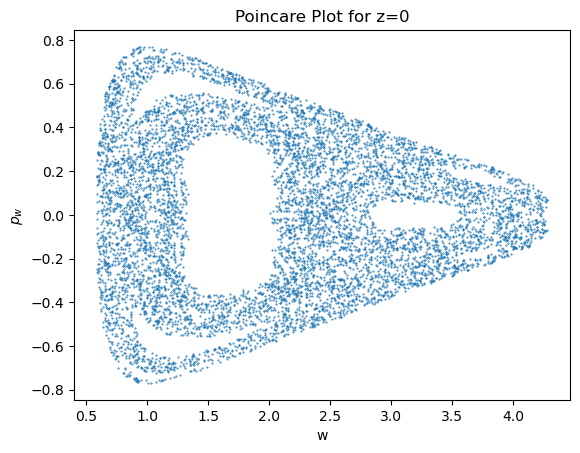

In [14]:

#* Poincare Plot
 
plt.scatter(sol.y_events[0][mask,0],sol.y_events[0][mask,3],s=0.2);
plt.title(r"Poincare Plot for z=0");
plt.xlabel(r"w");
plt.ylabel(r"$p_w$");

In [15]:
# plt.plot(sol.y[1])

In [16]:
energy=H(mu,sol.y.T) #Get the energy of given solutions

Text(0, 0.5, 'Energy')

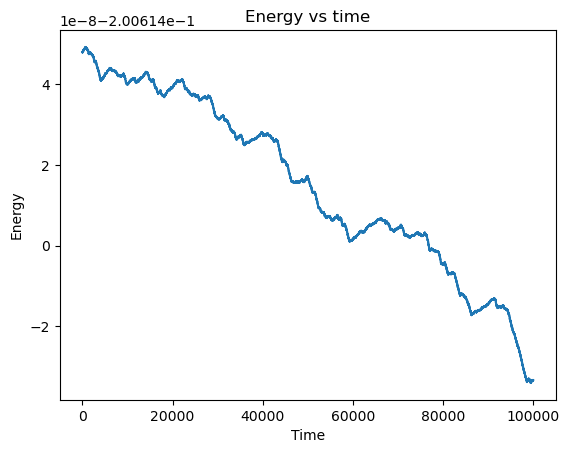

In [17]:
plt.plot(H(mu,sol.y.T)) 
plt.title("Energy vs time")
plt.xlabel("Time")
plt.ylabel("Energy")

#* The value of energy is within -0.2 (+/- 39e^(-8))

In [18]:
np.isclose(np.diff(H(mu,sol.y.T)),0).all()
#! All the values of energy are within 1e^(-8)

True

In [19]:

#! Faster Methods -----------------------------------

- <span style="color:red"> The following method generate the solutions very fast
 But it is very slow if you want to generate the Poincare
 Sections. We do not need this now. But I had put it for future reference </span>

##  <span style= "color:orange">Using LSODA wrapper </span>

In [20]:
#Faster Version of evolve method above
@nb.cfunc(lsoda_sig)
def faster_evolve(t,u, du,p):
    """
    Function for solving Differential Equation
    Args:
        t (float): Time Step
        x (np.ndarray): Shape (n,)

    Returns:
        Output (np.ndarray): Shape (n,) 
    """
    # w,z, phi,pw,pz,pphi=x
    du[0]= u[3]
    du[1]= u[4]
    du[2]= L/(mu*u[0]**2)

    du[3]= -mu*(-L**2 /(mu**2 * u[0]**3) + M*u[0]/((u[0]**2+u[1]**2)**(3/2)))
    du[4]=-mu*(M*u[1]/((u[0]**2+u[1]**2)**(3/2))+ alpha*np.tanh(u[1]/z0))
    du[5]=0.0

    # return np.array((dw,dz,dphi,dpw,dpz,dpphi))


In [21]:
funcptr=faster_evolve.address

In [22]:
u0=np.array([1.2,0.0,0.0,0.0,0.76,L]) #Initial conditions

In [23]:
t=np.arange(0.,100000.,1) #Time Steps for evolution

In [24]:
n_events=6000

@nb.cfunc(lsoda_sig)
def poincare_event(t,u,out,p):
    for i in nb.prange(n_events):
        out[i]=u[1]

# jitted_events = nb.njit(poincare_event)
event_fcn=poincare_event.address

In [25]:
t_span=np.array([min(t),max(t)])

In [26]:
t_eval=np.arange(0,10000,1)

In [27]:
usol, success = lsoda(funcptr, u0, t,atol=1e-10,rtol=1e-10)

In [28]:
#Now, to make the poincare plot

#---------------Work in Progress------------------


In [29]:
idx2 = np.where(np.sign(usol[:,1][:-1]) != np.sign(usol[:,1][1:]))[0] + 1
idx1=idx2-1

In [30]:
# f=lambda t: lsoda(funcptr,u0 , np.array([0,t]), mxstep=5000000,atol=1e-10, rtol=1e-10)[0][-1,1];
# t_eval=np.zeros_like(idx1)

# for i in range(1,len(idx2)):
#     t_eval[i]=brentq(f,t[idx1[i]],t[idx2[i]])

# # t_eval=np.array(t_eval)

In [31]:
# plt.plot(t,H(mu,usol))

## <span style="color: magenta">Lyponov Exponents</span>

## What will we try

- The first step is to try the things as was done for Lorenz System
- We will copy the code with minor changes

- In the next step, we will use the same thing as above, only difference will be that it will be faster than above

In [32]:
#Step 1

In [33]:
def chaotic_lyp(t,Y,alpha=alpha):
    """
    Function for solving the system of equation simultaneously with
    the Jacobian

    """

    #First system of equations
    
    w,z,phi,pw,pz,pphi=Y[:6]
    dw= pw
    dz= pz
    dphi= L/(mu*w**2)
    
    dpw= -mu*(-L**2 /((mu**2) * w**3) + M*w/((w**2+z**2)**(3/2)))
    dpz=-mu*(M*z/((w**2+z**2)**(3/2))+ alpha*np.tanh(z/z0))
    dpphi=0.0  

    dhdwdw=-mu*(3*L**2/((mu**2)*w**4)-3*M*w**2/((w**2+z**2)**(5/2))+M/((w**2+z**2)**(3/2)))
    dhdwdz= 3*M*mu*w*z/((w**2+z**2)**(5/2))
    dhdzdz=-mu*(-3*M*z**2/((w**2+z**2)**(5/2))+M/((w**2+z**2)**(3/2))+alpha*(1/(np.cosh(z/z0))**2)/z0)

    #Now calculate the jacobian
    J=np.array([

        [0., 0.,0.,1.,0.,0.],
        [0.,0.,0.,0.,1.,0.],
        [-2*L/(mu*w**3), 0.,0.,0.,0.,1/(mu*w**2)],
        [dhdwdw,dhdwdz,0.,0.,0.,2*L/(mu*w**3)],
        [dhdwdz,dhdzdz,0.,0.,0.,0.],
        [0.,0.,0.,0.,0.,0.]
    ])

    dY=Y[6:].reshape((6,6))
    dY_dt=np.dot(J,dY)

    return np.concatenate(([dw,dz,dphi,dpw,dpz,dpphi],dY_dt.flatten()))

In [34]:

#* Our Initial condition for the above system
ics1=np.array([1.2,0.0,0.0,0.0,0.76,L]+np.eye(6).flatten().tolist())

In [35]:
t_span = [0., 100000.] #! Time steps for integration
dt=0.01
iters=1000000
tf=iters*dt
ti=0
t_eval=np.linspace(ti,tf,iters) #! Time step for evaluation

In [36]:
# #* Solution using scipy Integrate
solution = integrate.solve_ivp(chaotic_lyp, t_span, ics1,'LSODA', t_eval=t_eval,args=(alpha,),atol=1e-11,rtol=1e-11)

In [37]:
# Extract solution
t = solution.t
traj = solution.y[:6, :]
d_traj = solution.y[6:, :]

In [38]:

#! Calculate the lyapunav exponents as done in the case of Lorenz system
#! This uses scipy solve_ivp result
lyapunov_exponents = np.zeros((len(t_eval),6))
for i in range(1, len(t_eval)):
    W = d_traj.T[i].reshape(6, 6)
    Q, R = np.linalg.qr(W)
    d_traj.T[i] = Q.flatten()
    lyapunov_exponents[i,:] = np.log(np.abs(np.diag(R))) / t_eval[i]

In [39]:
max_lyapunov_exponent=np.max(lyapunov_exponents,axis=1)

#! Our task is to get the maximum lyapunov exponent for each time

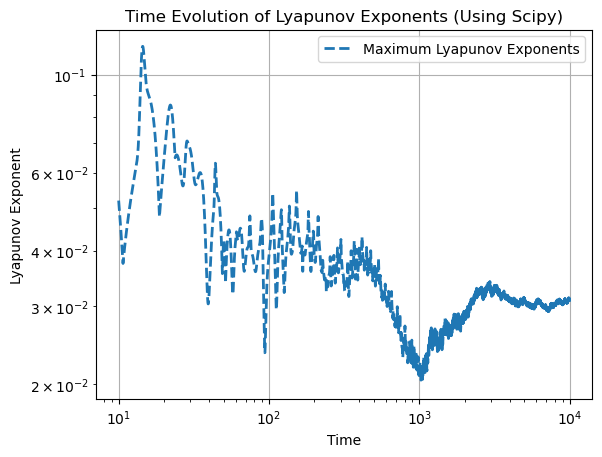

In [40]:
# Plot the Lyapunov exponents after 1000 units of time
plt.figure()
plt.loglog(t_eval[1000:], max_lyapunov_exponent[1000:], label='Maximum Lyapunov Exponents', linewidth=2, linestyle='--')
ax=plt.gca()
# ax.set_xscale("log", base=10)
# ax.set_yscale("log", base=10)
plt.xlabel('Time')
plt.ylabel('Lyapunov Exponent')
plt.legend()
# plt.xlim(1e4,1e6)
plt.grid(True)
plt.title('Time Evolution of Lyapunov Exponents (Using Scipy)')
plt.show()

In [41]:

#! Faster implementaton of above function
@nb.cfunc(lsoda_sig)
def faster_chaotic_system(t,u,du,p):
    """
    The same system as above but faster than above method. This uses Numba
    and Numbalsoda for faster evaluations
    """
    u_=nb.carray(u,(42,))
    w,z,phi,pw,pz,pphi=u_[:6]
    dw= pw
    dz= pz
    dphi= L/(mu*w**2)
    
    dpw= -mu*(-L**2 /((mu**2) * w**3) + M*w/((w**2+z**2)**(3/2)))
    dpz=-mu*(M*z/((w**2+z**2)**(3/2))+ alpha*np.tanh(z/z0))
    dpphi=0.0  

    dhdwdw=-mu*(3*L**2/((mu**2)*w**4)-3*M*w**2/((w**2+z**2)**(5/2))+M/((w**2+z**2)**(3/2)))
    dhdwdz= 3*M*mu*w*z/((w**2+z**2)**(5/2))
    dhdzdz=-mu*(-3*M*z**2/((w**2+z**2)**(5/2))+M/((w**2+z**2)**(3/2))+alpha*(1/(np.cosh(z/z0))**2)/z0)

    #Now calculate the jacobian

    J=np.array([
        [0., 0.,0.,1.,0.,0.],
        [0.,0.,0.,0.,1.,0.],
        [-2*L/(mu*w**3), 0.,0.,0.,0.,1/(mu*w**2)],
        [dhdwdw,dhdwdz,0.,0.,0.,2*L/(mu*w**3)],
        [dhdwdz,dhdzdz,0.,0.,0.,0.],
        [0.,0.,0.,0.,0.,0.]
    ])

    dY=u_[6:].reshape((6,6))
    dY_dt=np.dot(J,dY)
    dydtf=dY_dt.flatten()
    du_=np.zeros((42,),dtype=nb.float64)
    du_[:6]=np.array([dw,dz,dphi,dpw,dpz,dpphi])
    du_[6:]=dydtf

    for i in range(len(du_)):
        du[i]=du_[i]



In [42]:
funcptr=faster_chaotic_system.address #* Numba Ctype function

In [43]:
dt=0.01
iters=1000000
tf=iters*dt
ti=0
t_eval=np.linspace(ti,tf,iters) #! Evaluation times

In [44]:
# #* Our Initial condtions
u0=np.array([1.2,0.0,0.0,0.0,0.76,L]+np.eye(6).flatten().tolist())

In [45]:
usol, success = lsoda(funcptr, u0, t_eval=t_eval,atol=1e-11,rtol=1e-11,mxstep=100000)

In [46]:
usol_tra=usol[:,:6] #*Evolution of the phase space variables
dusol_tra=usol[:,6:] #* Evolution of tangent vectors

In [47]:

#! Calculate the lyapunav exponents as done in the case of Lorenz system
#! This uses scipy numbalsoda result
lyapunov_exponents2 = np.zeros((len(t_eval),6))
for i in range(1, len(t_eval)):
    W = dusol_tra[i].reshape(6, 6)
    Q, R = np.linalg.qr(W)
    dusol_tra[i] = Q.flatten()
    lyapunov_exponents2[i,:] = np.log(np.abs(np.diag(R))) / t_eval[i]

In [48]:
max_lyapunov_exponent2=np.max(lyapunov_exponents2,axis=1)

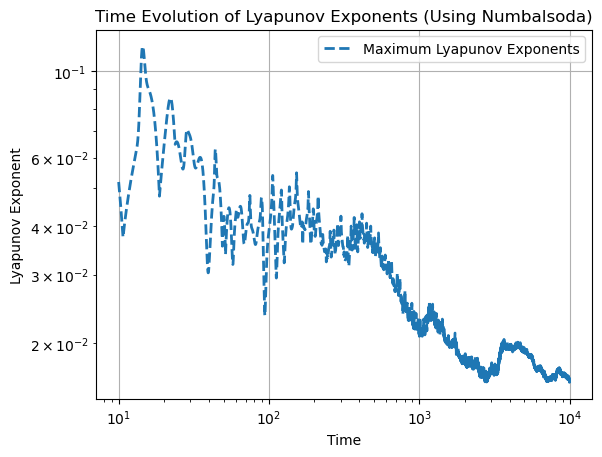

In [49]:
# Plot the Lyapunov exponents after 1000 units of time
plt.figure()
plt.plot(t_eval[1000:], max_lyapunov_exponent2[1000:], label='Maximum Lyapunov Exponents', linewidth=2, linestyle='--')
ax=plt.gca()
ax.set_xscale("log", base=10)
ax.set_yscale("log", base=10)
plt.xlabel('Time')
plt.ylabel('Lyapunov Exponent')
plt.legend()
# plt.xlim(1e4,1e6)
plt.grid(True)
plt.title('Time Evolution of Lyapunov Exponents (Using Numbalsoda)')
plt.show()

#### We will use another method to calculate the Lyapunov Exponent

This method is outlined in the following link
<span style="color: blue"> https://scicomp.stackexchange.com/a/36023/39504 </span>

In [50]:
# @nb.njit
def chaotic_system_LEC(t,Y,alpha):
    w,z,phi,pw,pz,pphi=Y[:6]
    dw= pw
    dz= pz
    dphi= L/(mu*w**2)
    
    dpw= -mu*(-L**2 /((mu**2) * w**3) + M*w/((w**2+z**2)**(3/2)))
    dpz=-mu*(M*z/((w**2+z**2)**(3/2))+ alpha*np.tanh(z/z0))
    dpphi=0.0  

    dhdwdw=-mu*(3*L**2/((mu**2)*w**4)-3*M*w**2/((w**2+z**2)**(5/2))+M/((w**2+z**2)**(3/2)))
    dhdwdz= 3*M*mu*w*z/((w**2+z**2)**(5/2))
    dhdzdz=-mu*(-3*M*z**2/((w**2+z**2)**(5/2))+M/((w**2+z**2)**(3/2))+alpha*(1/(np.cosh(z/z0))**2)/z0)

    J=np.array([

        [0., 0.,0.,1.,0.,0.],
        [0.,0.,0.,0.,1.,0.],
        [-2*L/(mu*w**3), 0.,0.,0.,0.,1/(mu*w**2)],
        [dhdwdw,dhdwdz,0.,0.,0.,2*L/(mu*w**3)],
        [dhdwdz,dhdzdz,0.,0.,0.,0.],
        [0.,0.,0.,0.,0.,0.]
    ])

    return np.array([dw,dz,dphi,dpw,dpz,dpphi]),J


In [51]:
def LEC_system(t,u,alpha):
    #x,y,z = u[:3]             # n=6
    U = u[6:42].reshape((6,6)) # size n square matrix, sub-array from n to n+n*n=n*(n+1)
    L = u[42:48]               # vector, sub-array from n*(n+1) to n*(n+1)+n=n*(n+2)
    f,Df = chaotic_system_LEC(t,u[:6],alpha)
    A = U.T.dot(Df.dot(U))
    dL = np.diag(A).copy();
    for i in range(6):
        A[i,i] = 0
        for j in range(i+1,6):
            A[i,j] = -A[j,i]
    dU = U.dot(A)
    return np.concatenate([f,dU.flatten(),dL])

In [52]:
u0=np.array([1.2,0.0,0.0,0.0,0.76,L])
U0 = np.identity(6)
L0 = np.zeros(6)
u0 = np.concatenate([u0, U0.flatten(), L0])

In [53]:
t_span = [0., 100000.]
dt=0.01
iters=1000000
tf=iters*dt
ti=0
t_eval=np.linspace(ti,tf,iters)

In [54]:
# Solve the Chaotic syste`m and the variational equations
solution_2 = integrate.solve_ivp(LEC_system, t_span, u0,'LSODA', t_eval=t_eval,args=(alpha,),atol=1e-11,rtol=1e-11)

In [55]:
L_ = np.max(solution_2.y.T[5000:,12:15].T/t_eval[5000:],axis=0)

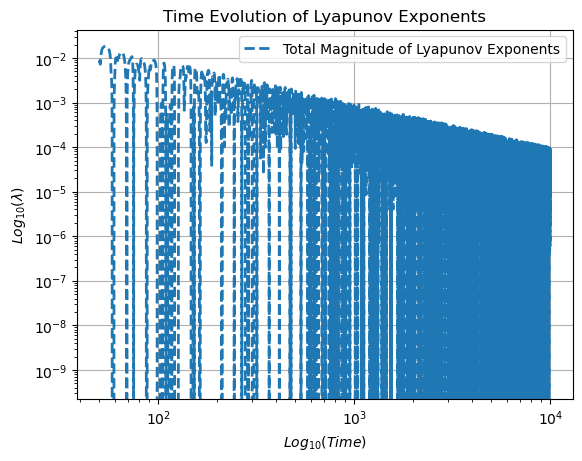

In [61]:
# Plot the Lyapunov exponents
plt.figure()
plt.loglog(t_eval[5000:],L_, label='Total Magnitude of Lyapunov Exponents', linewidth=2, linestyle='--')
ax=plt.gca()
# ax.set_xscale("log", base=10)
# ax.set_yscale("log", base=10)
plt.xlabel(r'$Log_{10}(Time)$')
plt.ylabel(r'$Log_{10}(\lambda)$')
plt.legend()
plt.grid(True)
plt.title('Time Evolution of Lyapunov Exponents')
plt.show()

In [85]:
#We will use another method usign external Library JITCODE
#This library does symbolic manipulations

In [62]:
from jitcode import y,jitcode_lyap
import symengine as sye

In [74]:
f = [y(3),
     y(4),
     L/(mu*y(0)**2),
     -mu*(-L**2 /((mu**2) * y(0)**3) + M*y(0)/((y(0)**2+y(1)**2)**(3/2))),
     -mu*(M*y(1)/((y(0)**2+y(1)**2)**(3/2))+ alpha*sye.tanh(y(1)/z0)),
     0.0
	]

In [75]:
ics=np.array([1.2,0.0,0.0,0.0,0.76,L])

In [76]:
n = len(f)
ODE = jitcode_lyap(f, n_lyap=n)
ODE.set_integrator("vode")
ODE.set_initial_value(ics,0.0)

Generating, compiling, and loading C code.
generated C code for f
generated symbolic Jacobian
generated C code for Jacobian


In [77]:

times = np.arange(10,10000,10)
lyaps = []
for time in times:
	lyaps.append(ODE.integrate(time)[1])

In [81]:
lyaps = np.max(np.vstack(lyaps),axis=1)

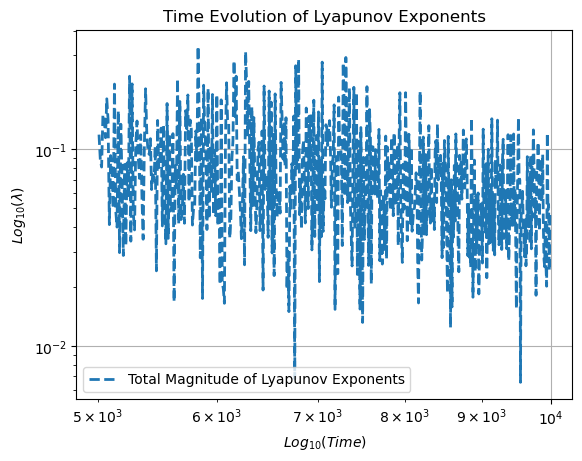

In [84]:
# plt.loglog(times,lyaps)
# Plot the Lyapunov exponents
plt.figure()
plt.loglog(times[500:],lyaps[500:], label='Total Magnitude of Lyapunov Exponents', linewidth=2, linestyle='--')
ax=plt.gca()
# ax.set_xscale("log", base=10)
# ax.set_yscale("log", base=10)
plt.xlabel(r'$Log_{10}(Time)$')
plt.ylabel(r'$Log_{10}(\lambda)$')
plt.legend()
plt.grid(True)
plt.title('Time Evolution of Lyapunov Exponents')
plt.show()